In [27]:
import sys
sys.path.append("/Users/zacharystarr/Desktop/TrafficMonitoring-usingYOLO/")
import os
os.chdir("/Users/zacharystarr/Desktop/TrafficMonitoring-usingYOLO/")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime, timedelta
import params

labelMap = ["pedestrian",     "bicycle",    "car",    "motorbike",    "aeroplane",    "bus",    "train",
            "truck",          "boat"]

myFmt = mdates.DateFormatter('%H:%M')

In [28]:
def CreateMovingAverage(input, inputTimes, window_size):
    result = []
    resultTimes = []
    for i in range(int(window_size - 1)):
        result.append(input[i])
        resultTimes.append(inputTimes[i])
    movingAverage = sum(input[:window_size])
    result.append(movingAverage/window_size)
    resultTimes.append(inputTimes[window_size - 1])
    for i in range (len(input) - window_size):
        movingAverage += (input[i + window_size] - input[i])
        result.append(movingAverage/window_size)
        resultTimes.append(inputTimes[i + window_size])
    del result[:window_size-2]
    del resultTimes [:window_size-2]
        
    return result, resultTimes

In [29]:
def ParseLabelList(text):
    text = text.split(', ')
    whiteList = []
    for i in text:
        if i == "all":
            whiteList.append("all")
        elif i in labelMap:
            whiteList.append(labelMap.index(i))
        elif i not in labelMap:
            print("could not find {} in the label map!".format(i))
    return whiteList, text

In [30]:
def ReadRawTime(rawTime):
    if len(rawTime) < 6:
        x = "0"
        rawTime = x + rawTime
    Time = datetime.strptime(f"{rawTime[:2]}:{rawTime[2:4]}:{rawTime[4:]}", "%H:%M:%S")
    return Time

In [31]:
def ReadItemTime(textItem):
    rawTime = textItem.split(',')[1]
    Time = datetime.strptime(f"{rawTime[:2]}:{rawTime[2:4]}:{rawTime[4:]}", "%H:%M:%S")
    return Time

In [32]:
folder = params.RawData_Folder
collections = sorted(os.listdir("{}/".format(folder)))

msg = "Select File to Read:\n"
count = 0
for item in collections:
    msg = msg + "{}: {}".format(count, str(item)) + "\n"
    count += 1

print(msg)
readLoop = True
fileInput = input("Select File: ")
file = collections[int(fileInput)]
fileName = file
print(file)

Select File to Read:
0: BikeLane Sample 1,122,01:35:12,16:10:20.txt
1: Corporation Compiled,3489,02:53:09,07:30:00.txt
2: Corporation Sample 1,3053,02:23:31,07:30:00.txt
3: Corporation Sample 2,436,00:29:38,09:53:00.txt
4: Data Collected @ Sat Aug 19 07:10:14 2023.txt
5: Data Collected @ Sat Aug 19 07:13:42 2023.txt
6: Data Collected @ Sat Aug 19 07:21:19 2023.txt
7: Data Collected @ Sat Aug 19 07:32:00 2023.txt
8: Data Collected @ Sat Aug 19 07:33:52 2023.txt
9: Jurong East Sample 1,1007,01:56:28,14:00:00.txt
10: Lakeside Sample 1,1446,01:42:47,11:30:00.txt
11: Westgate Compiled,5589,04:10:51,16:25:00.txt
12: Westgate Sample 1,2529,01:54:51,16:25:00.txt
13: Westgate Sample 2,1064,00:34:02,18:19:00.txt
14: Westgate Sample 3,1153,00:50:58,18:49:36.txt
15: Westgate Sample 4,843,00:51:00,19:40:00.txt

Westgate Compiled,5589,04:10:51,16:25:00.txt


In [33]:
timeInputRaw = input("Enter Time Recording Started (XX:XX:XX): ")
startInput = timeInputRaw.replace(':', '')
if startInput == "":
    rename = False
    metadata = file.split(",")
    if len(metadata) >= 4:
        metadata[3] = metadata[3].replace('.txt', '')
        timeInput = metadata[3].replace(':', '')
        startTime = ReadRawTime(timeInput)
    else:
        timeInput = "000000"    
        startTime = datetime(2000, 1, 1, 0, 0, 0)
else:
    rename = True
    metadata = file.split(",")
    if len(metadata) >= 4:
        metadata[3] = f"{timeInputRaw}.txt"
        filePath = (f"{os.getcwd()}/data/raw_data/{file}")
        newFileName = ",".join(metadata)
        os.rename(filePath, f"{os.getcwd()}/data/raw_data/{newFileName}")
    else:
        metadata[2] = metadata[2].replace('.txt', '')
        metadata.append(f"{timeInputRaw}.txt")
        filePath = (f"{os.getcwd()}/data/raw_data/{file}")
        newFileName = ",".join(metadata)
        os.rename(filePath, f"{os.getcwd()}/data/raw_data/{newFileName}")
    metadata[3] = metadata[3].replace('.txt', '')
    startTime = ReadRawTime(metadata[3].replace(':', ''))
timeAdjuster = timedelta(0, startTime.second,0,0,startTime.minute,startTime.hour)

intervalInput = input("Enter Interval (XX:XX:XX): ").replace(":", "")
if intervalInput == "":
    if rename:
        file = (f"{os.getcwd()}/data/raw_data/{newFileName}")
        print(file)
    elif not rename:
        file = (f"{os.getcwd()}/data/raw_data/{file}")
    with open(f"{file}", "r") as text:
        lines = text.readlines()
        finalTime = ReadItemTime(lines[len(lines) - 1])
    interval = timedelta(0, finalTime.second, 0, 0, finalTime.minute, finalTime.hour)
    interval = interval/12
    interval_seconds = int(interval.total_seconds())
    interval_minutes = int(interval_seconds/60)
    interval = timedelta(0, 0, 0, 0, interval_minutes, 0)

    vphMultiplier = 60/interval_minutes
else:
    if rename:
        file = (f"{os.getcwd()}/data/raw_data/{newFileName}")
        print(file)
    elif not rename:
        file = (f"{os.getcwd()}/data/raw_data/{file}")
    interval = ReadRawTime(intervalInput)
    interval = timedelta(0, interval.second, 0, 0, interval.minute, interval.hour)
    interval_seconds = int(interval.total_seconds())
    interval_minutes = int(interval_seconds/60)

    vphMultiplier = 60/interval_minutes
#vphMultiplier

In [34]:
def MeetsTimeCondition(time, initTime, finalTime):
    if initTime.time() <= time.time() <= finalTime.time():
        return True
    else:
        return False

In [35]:
def CreateData(dataset):
    times = []
    vehicles = []
    vehiclesPerHour = []

    leftBound = startTime
    rightBound = startTime + interval
    middleBound = startTime + interval/2

    vehiclecount = 0
    totalvehiclecount = 0
    for item in dataset:
        time = ReadItemTime(item) + timeAdjuster
        if MeetsTimeCondition(time, leftBound, rightBound):
            vehiclecount += 1
            totalvehiclecount += 1
        elif not MeetsTimeCondition(time, leftBound, rightBound):
            if totalvehiclecount != len(lines):
                vehicles.append(vehiclecount)
                vPerHour = vehiclecount * vphMultiplier
                vehiclesPerHour.append(vPerHour)
                #times.append(f"{leftBound.time()}\n-\n{rightBound.time()}")
                times.append(middleBound)
                leftBound += interval
                rightBound += interval
                middleBound += interval
                vehiclecount = 1
                totalvehiclecount += 1
    return times, vehicles, vehiclesPerHour

In [36]:
def Filter(dataset, vehicle_type):
    count = 0
    removalList = []
    for item in dataset:
        vehicleType = int(item.split(',')[3])
        if vehicleType != vehicle_type:
            removalList.append(dataset[count])
        count += 1

    dataset = [i for i in dataset if i not in removalList]
    
    return dataset

In [37]:
def Graph(times, vehicles, vehiclesPerHour, graphName,  show_total=False):
    yMax = max(vehiclesPerHour) * 1.05
    yMin = min(vehiclesPerHour) * 0.95
    
    graphName.ylim(yMin, yMax) if graphName == plt else None
    graphName.grid(True, linestyle=':')

    graphName.figure(figsize=(15, 6)) if graphName == plt else None
    #rcParams['figure.figsize'] = len(times)*1.2, len(times)*1.2
    if show_total:
        for xy in zip(times, vehicles):
            xy = (xy[0], round(xy[1], 2))
            xyAnnotation = list(xy)
            graphName.annotate("(" + str(xyAnnotation[1]) + ")", xy=xy)
        graphName.plot(times, vehicles, "r--o", label="Total Vehicles")
    if not show_total:
        graphName.plot_date(times, vehiclesPerHour, "m-o", xdate=True, label="Vehicles Per Hour")
        #graphName.plot(times, vehiclesPerHour, "m--o", label = "Vehicles Per Hour")
        for xy in zip(times, vehiclesPerHour):
            xy = (xy[0], round(xy[1], 2))
            xyAnnotation = list(xy)
            graphName.annotate("(" + str(xyAnnotation[1]) + ")", xy=xy)
            #graphName.annotate("(" + str(xy).split(', ')[5], xy=xy)
    graphName.legend()
    graphName.title(fileName
                    .replace(".txt", "")) if graphName == plt else None
    graphName.xlabel("Time") if graphName == plt else None
    graphName.ylabel("# of Vehicles") if graphName == plt else None

In [38]:
def addToGraph(times, vehicles, vehiclesPerHour, vehicleName, graphName, show_total=False, show_label=True):
    alpha = 1
    if show_total:
        if show_label:
            for xy in zip(times, vehicles):
                xy = (xy[0], round(xy[1], 2))
                xyAnnotation = list(xy)
                graphName.annotate("(" + str(xyAnnotation[1]) + ")", xy=xy)
        graphName.plot_date(times, vehicles, "--o", xdate=True, label=f"Total {vehicleName}s".capitalize()) if vehicleName != "bus" else graphName.plot_date(times, vehicles, "--o", xdate=True, label=f"Total {vehicleName}es".capitalize())
        #graphName.plot(times, vehicles, "--o", label=f"Total {vehicleName}s".capitalize(), alpha = alpha) if vehicleName != "bus" else graphName.plot(times, vehicles, "--o", label=f"Total {vehicleName}es".capitalize(), alpha = alpha)
    if not show_total:
        if show_label:
            for xy in zip(times, vehiclesPerHour):
                xy = (xy[0], round(xy[1], 2))
                xyAnnotation = list(xy)
                graphName.annotate("(" + str(xyAnnotation[1]) + ")", xy=xy)
        graphName.plot(times, vehiclesPerHour, "--o", label = f"{vehicleName}s Per Hour".capitalize()) if vehicleName != "bus" else graphName.plot(times, vehiclesPerHour, "--o", label = f"{vehicleName}es Per Hour".capitalize())
    graphName.grid(True, linestyle=':')
    graphName.legend()

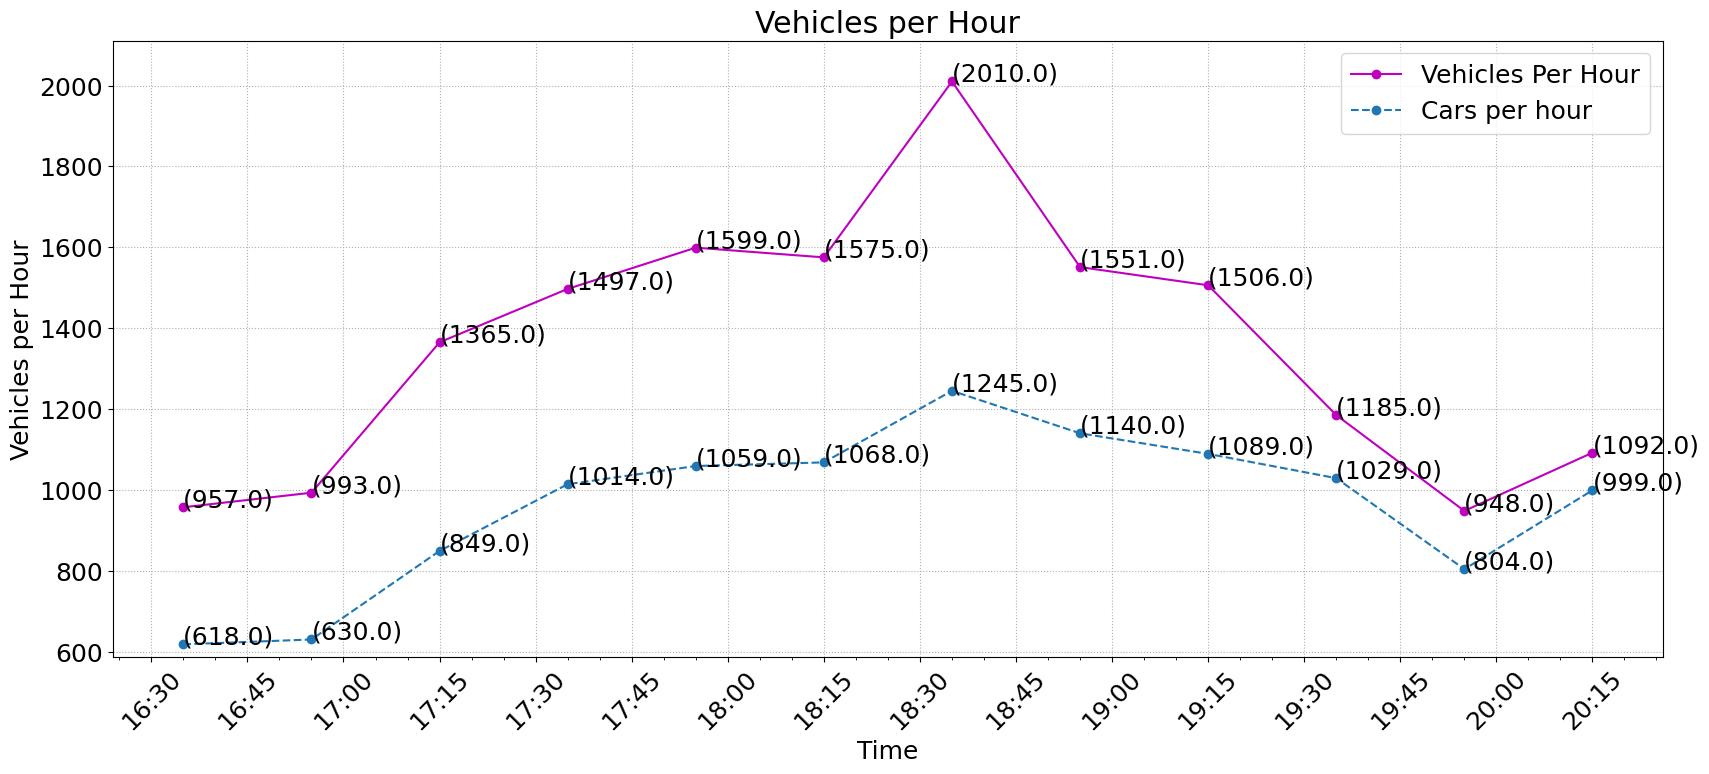

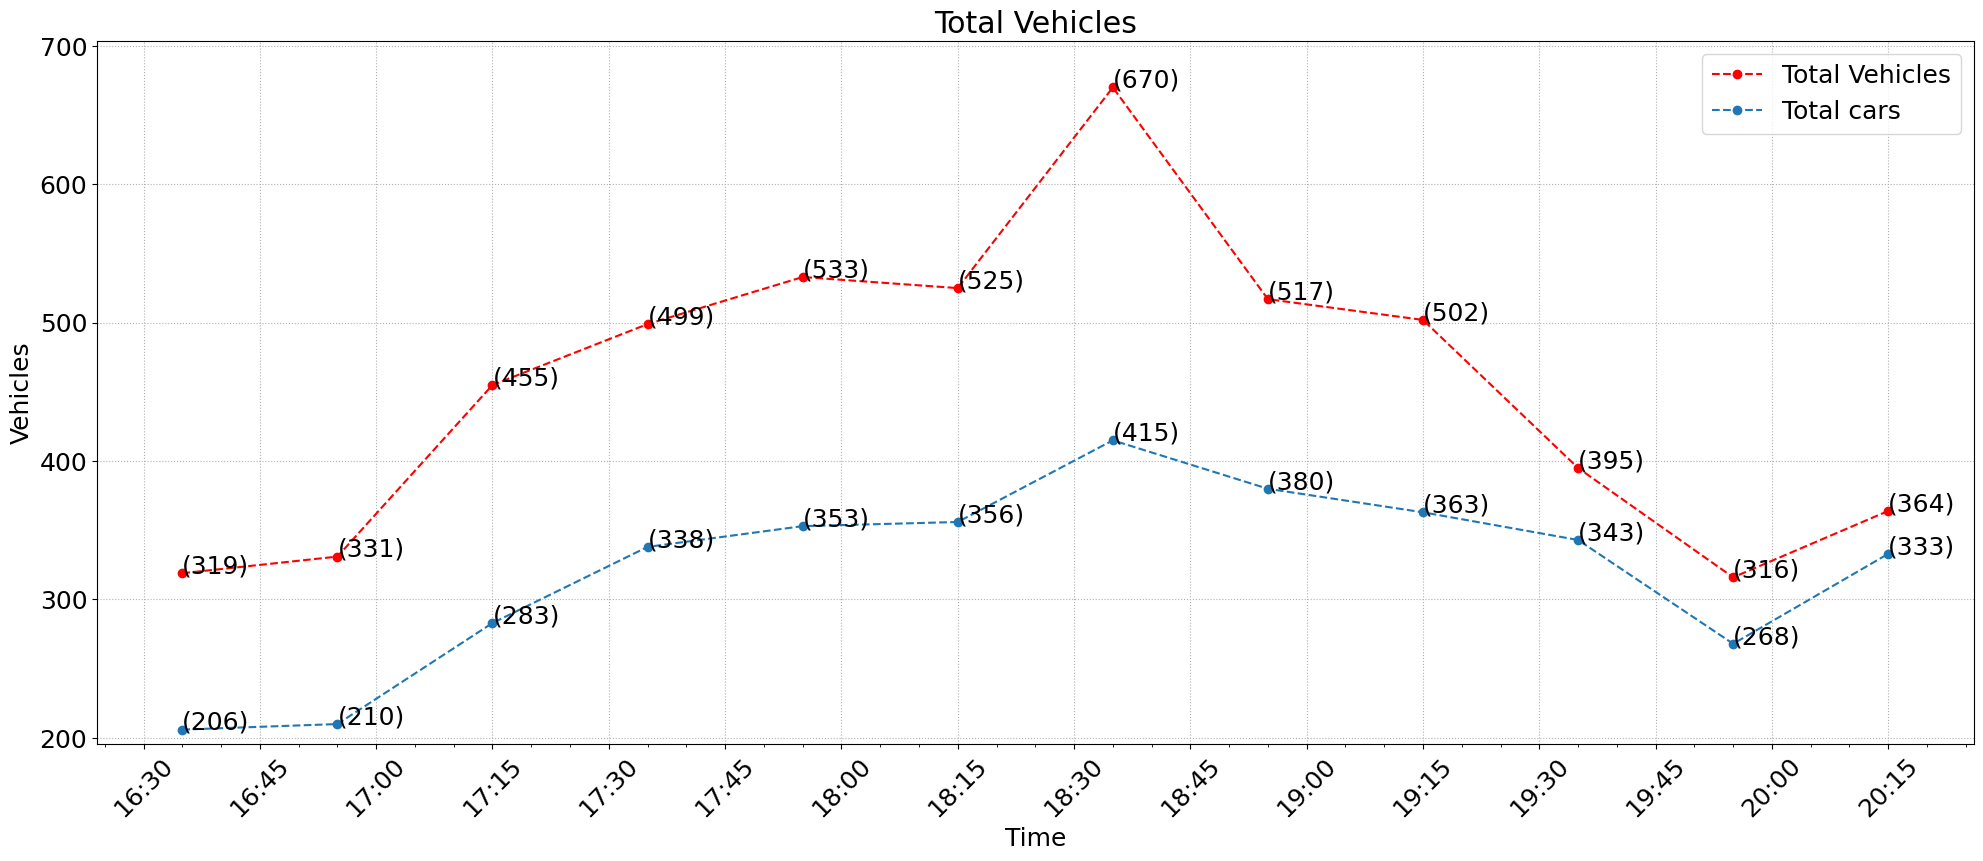

In [39]:
with open(f"{file}", "r") as text:
    lines = text.readlines()

graphInput = input("Input additional vehicles: ")

isolateSpecific = False
if graphInput != '':
    if graphInput[0] == 'j':
        isolateSpecific = True
        graphInput = graphInput.replace("just ", "")

additionalVehicles, graphInput = ParseLabelList(graphInput)
    
times, vehicles, vehiclesPerHour = CreateData(lines)
movingAverage, mAveTimes = CreateMovingAverage(vehiclesPerHour, times, int(len(times)/3))


yMax = max(vehiclesPerHour) * 1.05
yMin = min(vehiclesPerHour) * 0.95

yMaxV = max(vehicles) * 1.05
yMinV = min(vehicles) * 0.95

fig, (ax1) = plt.subplots(1, 1, figsize = (20, 8))

fig2, (ax2) = plt.subplots(1, 1, figsize= (20, 8))

#fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 15))

plt.tight_layout()
#plt.subplots_adjust(hspace=0.3)
plt.rcParams['font.size'] = 18

ax1.set(title = "Vehicles per Hour", xlabel="Time", ylabel="Vehicles per Hour")
ax1.xaxis.set_major_formatter(myFmt)
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 15, 30, 45, 60]))
ax1.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=[5, 10, 20, 25, 35, 40, 50, 55]))
ax1.tick_params('x', labelrotation=45)

ax2.set(title = "Total Vehicles", xlabel="Time", ylabel="Vehicles")
ax2.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 15, 30, 45, 60]))
ax2.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=[5, 10, 20, 25, 35, 40, 50, 55]))
ax2.tick_params('x', labelrotation=45)

if not isolateSpecific:
    Graph(times, vehicles, vehiclesPerHour, ax1)
    #addToGraph(mAveTimes, vehicles, movingAverage, "Moving Average", ax1, show_label=False)
    Graph(times, vehicles, vehiclesPerHour, ax2, show_total=True)

for item in additionalVehicles:
    addList = Filter(lines, item)
    addTimes, adds, addsPerHour = CreateData(addList)

    yMinAdd = min(addsPerHour)
    yMinAddV = min(adds)
    if yMinAdd < yMin:
        yMin = yMinAdd * 0.95
    if yMinAddV < yMinV:
        yMinV = yMinAddV * 0.95
    
    addToGraph(addTimes, adds, addsPerHour, graphInput[additionalVehicles.index(item)], ax1)
    addToGraph(addTimes, adds, addsPerHour, graphInput[additionalVehicles.index(item)], ax2, show_total=True)

if not isolateSpecific:
    ax1.set_ylim(yMin, yMax)
    ax2.set_ylim(yMinV, yMaxV)